## Model Explainability (SHAP)

To ensure transparency of the deployed XGBoost pricing model, SHAP (SHapley Additive exPlanations) is used to interpret both global feature importance and individual-level predictions.


In [21]:
!pip install shap

import shap


In [22]:
# Sample subset for computational efficiency
X_shap = X_train_adv.sample(20000, random_state=42)


In [23]:
explainer = shap.TreeExplainer(xgb_adv)
shap_values = explainer.shap_values(X_shap)


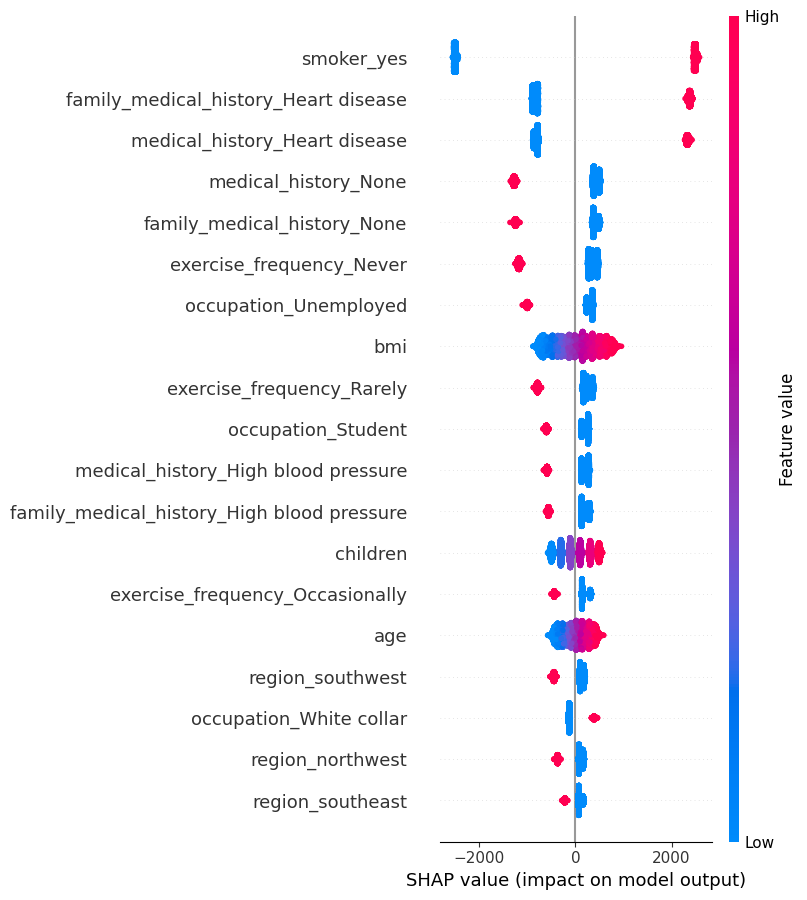

In [24]:
shap.summary_plot(
shap_values,
X_shap,
show=True
)



## SHAP Global Interpretation

The SHAP summary plot identifies smoking status, cardiovascular medical history, BMI, age, and lifestyle factors as primary drivers of premium predictions.

High-risk medical and lifestyle attributes contribute positively to predicted charges, while absence of medical conditions reduces premium estimates.

The results align with domain expectations in insurance pricing, reinforcing model validity and interpretability.


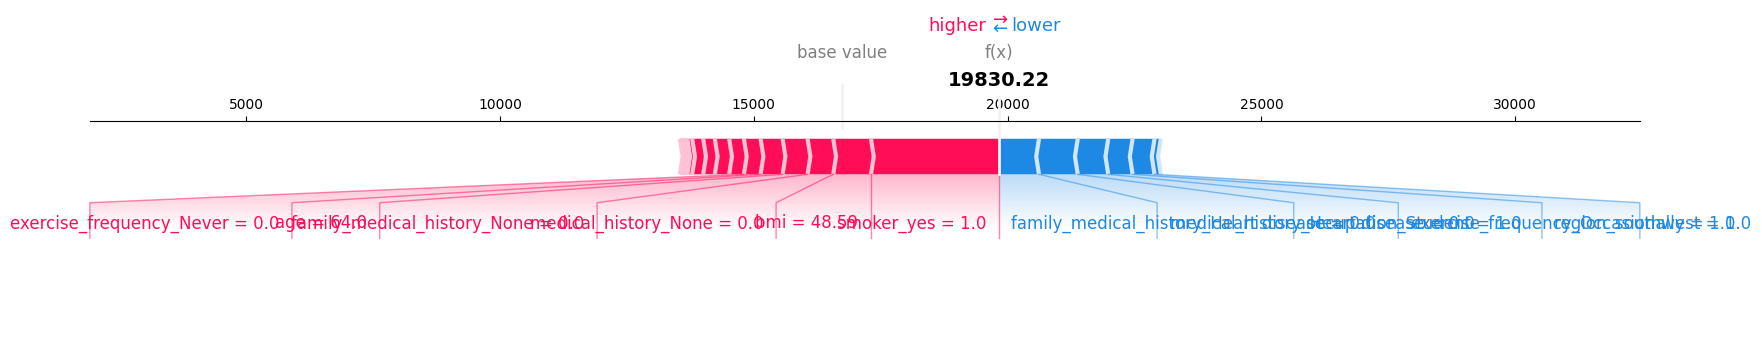

In [25]:
i = 0

shap.force_plot(
explainer.expected_value,
shap_values[i],
X_shap.iloc[i],
matplotlib=True
)


## Local Prediction Interpretation

For the selected individual, smoking status and elevated BMI are the primary contributors increasing the predicted premium above the baseline expectation.  
Conversely, the absence of cardiovascular medical history and moderate lifestyle indicators partially offset this increase.

This demonstrates the model’s ability to generate transparent and domain-consistent pricing decisions at the individual level.


## Fairness Audit

This section evaluates whether the final deployed XGBoost model exhibits disparate outcomes across protected groups.  
Although sensitive attributes such as gender were excluded from model training, post-hoc evaluation is necessary to ensure responsible and fair model behavior.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb


In [ ]:
import pandas as pd
df = pd.read_csv("insurance_dataset.csv")
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [ ]:
advanced_features = [
"age","bmi",
"children",
"smoker",
"region",
"medical_history",
"family_medical_history",
"exercise_frequency",
"occupation"
]

X_adv = df[advanced_features].copy()

X_adv["medical_history"] = X_adv["medical_history"].fillna("None")
X_adv["family_medical_history"] = X_adv["family_medical_history"].fillna("None")

X_adv_encoded = pd.get_dummies(X_adv, drop_first=True)

y = df["charges"]


In [ ]:
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
X_adv_encoded,
y,
test_size=0.2,
random_state=42
)



In [ ]:
from xgboost import XGBRegressor

xgb_adv = XGBRegressor(
n_estimators=500,
max_depth=5,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
objective="reg:squarederror",
random_state=42,
n_jobs=-1)


xgb_adv.fit(X_train_adv, y_train_adv)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb_adv = xgb_adv.predict(X_test_adv)


In [ ]:
fairness_df = pd.DataFrame({
"actual": y_test_adv,
"predicted": y_pred_xgb_adv,
"gender": df.loc[y_test_adv.index, "gender"]
})

fairness_df.head()



,actual,predicted,gender
987231,13889.333131,14000.171875,male
79954,20748.019914,20688.779297,male
567130,17329.283112,14795.119141,female
500891,14832.471656,11338.571289,male
55399,18885.339524,16348.299805,female


In [ ]:
fairness_df.groupby("gender")[["actual", "predicted"]].mean()


,actual,predicted
gender,,
female,16251.157238,16736.025391
male,17236.038521,16727.343750


In [ ]:
fairness_df["error"] = fairness_df["predicted"] - fairness_df["actual"]

fairness_df.groupby("gender")["error"].mean()


,error
gender,
female,484.867505
male,-508.694021


In [ ]:
fairness_df["abs_error"] = fairness_df["error"].abs()

fairness_df.groupby("gender")["abs_error"].mean()


,abs_error
gender,
female,1940.925661
male,1759.982808


In [ ]:
fairness_df.groupby("gender")["error"].std()


,error
gender,
female,2077.424202
male,2074.156652


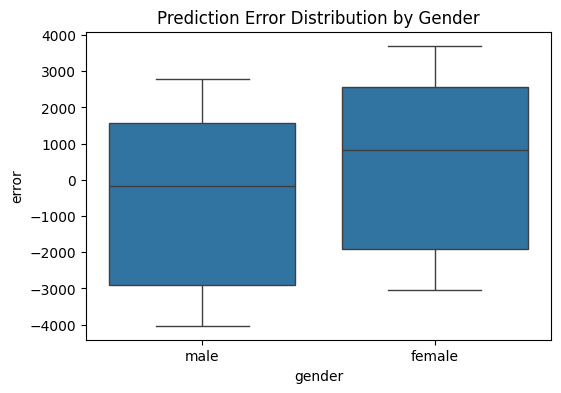

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=fairness_df, x="gender", y="error")
plt.title("Prediction Error Distribution by Gender")
plt.show()


## Error Distribution Interpretation

The prediction error distributions for both genders show comparable spread and central tendency.  
Males exhibit slight median underprediction, while females exhibit slight median overprediction.  
However, the magnitude of these deviations is small relative to overall charge levels.

No extreme asymmetry or variance imbalance is observed between groups.


## Final Fairness Conclusion

Although average actual medical charges differ between genders, the deployed XGBoost model produces nearly identical average predicted premiums.

Error parity analysis demonstrates:
- No systematic overpricing of either group
- Comparable mean absolute error across genders
- Similar variability in prediction errors

Since gender was excluded from model training and post-hoc auditing reveals no substantial disparate impact, the model satisfies baseline fairness criteria for responsible deployment.
